# Problem Statement

In this example I will build a classifier for churn prediction using a dataset from telecomm industry. You can find the data set in github in the following links.

https://github.com/abulbasar/data/tree/master/Churn%20prediction

There are two files 
- churn-bigml-80.csv training data
- churn-bigml-20.csv test data



In [1]:
import xgboost as xgb
import pandas as pd
from sklearn import *
import matplotlib.pyplot as plt

%matplotlib inline

Load the training data

In [2]:
df_train = pd.read_csv("/data/churn-bigml-80.csv")
df_train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Let's check number of records, number of columns, types of columns and whether the data contains NULL values.

As we see it contains 2665 records, 20 columns, and no null values. There are three catagorical values. 

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

Let's check distribution of the output class. As it shows it contains 85% records are negative. It gives a sense of desired accuracy - which is closure to 90% or more. 

In [4]:
df_train.Churn.value_counts()

False    2278
True      388
Name: Churn, dtype: int64

In [5]:
df_train.Churn.value_counts()/len(df_train)

False    0.854464
True     0.145536
Name: Churn, dtype: float64

In [6]:
df_train.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

Loaded the test data and performed similar analysis as before.

In [7]:
df_test = pd.read_csv("/data/churn-bigml-20.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   667 non-null    object 
 1   Account length          667 non-null    int64  
 2   Area code               667 non-null    int64  
 3   International plan      667 non-null    object 
 4   Voice mail plan         667 non-null    object 
 5   Number vmail messages   667 non-null    int64  
 6   Total day minutes       667 non-null    float64
 7   Total day calls         667 non-null    int64  
 8   Total day charge        667 non-null    float64
 9   Total eve minutes       667 non-null    float64
 10  Total eve calls         667 non-null    int64  
 11  Total eve charge        667 non-null    float64
 12  Total night minutes     667 non-null    float64
 13  Total night calls       667 non-null    int64  
 14  Total night charge      667 non-null    fl

In [8]:
df_test.Churn.value_counts()/len(df_test)

False    0.857571
True     0.142429
Name: Churn, dtype: float64

In [9]:
len(df_test)/len(df_train)

0.2501875468867217

Sort out of categorical and numeric columns so that it can be passed to pipeline for pre-proceessing steps. In the processing steps, we are doing the following 
- replace any missing numeric values with column median
- perform standard scaling for numeric values
- one hot encode the categorical columns


Althought the Area Code is numeric, here I am considering this as categorical since it is a qualitative variable in nature.

In [10]:
cat_columns = ['State', 'Area code', 'International plan', 'Voice mail plan']
num_columns = ['Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls']

In [11]:
target = "Churn"
X_train = df_train.drop(columns=target)
y_train = df_train[target]
X_test = df_test.drop(columns=target)
y_test = df_test[target]

In [12]:
cat_pipe = pipeline.Pipeline([
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='error', drop="first"))
]) 

num_pipe = pipeline.Pipeline([
    ('imputer', impute.SimpleImputer(strategy='median')),
    ('scaler', preprocessing.StandardScaler()),
])

preprocessing_pipe = compose.ColumnTransformer([
    ("cat", cat_pipe, cat_columns),
    ("num", num_pipe, num_columns)
])

X_train = preprocessing_pipe.fit_transform(X_train)
X_test = preprocessing_pipe.transform(X_test)

In [13]:
pd.DataFrame(X_train.toarray()).describe()

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,...,2.666000e+03,2.666000e+03,2.666000e+03,2.666000e+03,2.666000e+03,2.666000e+03,2.666000e+03,2.666000e+03,2.666000e+03,2.666000e+03
mean,0.024756,0.017629,0.016879,0.009002,0.022131,0.022131,0.016879,0.019130,0.020255,0.018380,...,-1.179352e-16,3.275699e-16,2.915897e-16,5.654392e-16,-5.730183e-17,-2.760149e-16,-2.013893e-16,-2.946297e-18,5.267937e-16,4.839007e-17
std,0.155410,0.131625,0.128843,0.094470,0.147136,0.147136,0.128843,0.137007,0.140898,0.134345,...,1.000188e+00,1.000188e+00,1.000188e+00,1.000188e+00,1.000188e+00,1.000188e+00,1.000188e+00,1.000188e+00,1.000188e+00,1.000188e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.933617e+00,-4.962065e+00,-3.933688e+00,-3.101565e+00,-3.456440e+00,-3.100065e+00,-3.672045e+00,-1.819157e+00,-3.672907e+00,-1.191955e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.887477e-01,-6.460883e-01,-6.889229e-01,-6.744811e-01,-6.750593e-01,-6.741347e-01,-6.230740e-01,-5.975267e-01,-6.171222e-01,-4.291724e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.008679e-02,-1.172304e-03,1.083774e-02,-3.730931e-04,-5.467553e-03,-1.177149e-03,-1.327980e-02,-1.903165e-01,-1.925127e-02,-4.291724e-01
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.814391e-01,6.933526e-01,6.805757e-01,6.954009e-01,6.641242e-01,6.947594e-01,6.682549e-01,6.241038e-01,6.716218e-01,3.336100e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.205881e+00,3.471452e+00,3.204795e+00,3.817767e+00,3.393998e+00,3.815532e+00,3.502005e+00,6.325047e+00,3.501544e+00,5.673087e+00


Build a basic logistic regression model and decision tree models and check the accuracy. Basic logistic regression model gives accuracy of 85%. 

In [14]:
est = linear_model.LogisticRegression(solver="liblinear")
est.fit(X_train, y_train)
y_test_pred = est.predict(X_test)
est.score(X_test, y_test)

0.8545727136431784

In [15]:
est = tree.DecisionTreeClassifier(max_depth=6)
est.fit(X_train, y_train)
y_test_pred = est.predict(X_test)
est.score(X_test, y_test)

0.9535232383808095

Print classification report. The report shows that precision and recall score quite poor. Accuracy is 85%. Confusion metrics shows a high number of false positive and false negatives.

In [16]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.97      0.98      0.97       572
        True       0.87      0.79      0.83        95

    accuracy                           0.95       667
   macro avg       0.92      0.89      0.90       667
weighted avg       0.95      0.95      0.95       667



In [17]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[561,  11],
       [ 20,  75]])

Next, we build a similar model using XGBoost. Performance the model is slightly better than logistic regression model.

In [43]:
eval_sets = [
    (X_train, y_train),
    (X_test, y_test)
]

cls = xgb.XGBRFClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.1,  
                          colsample_bytree = 0.99,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=100, 
                          reg_alpha = 0.003,
                          max_depth=10, 
                          gamma=10,
                          min_child_weight = 1
                          
                         )

print(cls.fit(X_train
              , y_train
              , eval_set = eval_sets
              , early_stopping_rounds = 10
              , eval_metric = ["error", "logloss"]
              , verbose = True
             ))
print("test accuracy: " , cls.score(X_test, y_test))

[0]	validation_0-error:0.044636	validation_0-logloss:1.56424	validation_1-error:0.043478	validation_1-logloss:1.30105
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.99, gamma=10, learning_rate=100.0,
                max_delta_step=0, max_depth=10, min_child_weight=1,
                missing=None, n_estimators=100, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0.003,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
                subsample=0.8, verbosity=1)
test accuracy:  0.9565217391304348


In [19]:
cls.evals_result()

{'validation_0': {'error': [0.044636], 'logloss': [0.685241]},
 'validation_1': {'error': [0.043478], 'logloss': [0.68529]}}

In [20]:
y_test_pred = cls.predict(X_test)

In [21]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[566,   6],
       [ 23,  72]])

In [22]:
y_test_prob = cls.predict_proba(X_test)[:, 1]
y_test_prob

array([0.49532136, 0.5033076 , 0.50276643, 0.4953032 , 0.4953032 ,
       0.49530497, 0.49530637, 0.4997355 , 0.49530464, 0.4953086 ,
       0.49531177, 0.495819  , 0.49530464, 0.49530464, 0.49530464,
       0.49532348, 0.49618483, 0.49530637, 0.4953032 , 0.496843  ,
       0.4953032 , 0.4953032 , 0.495819  , 0.4953032 , 0.49530497,
       0.49530464, 0.4953032 , 0.49530464, 0.4953106 , 0.4958201 ,
       0.49530464, 0.4953032 , 0.49530497, 0.49530464, 0.5033253 ,
       0.5011071 , 0.495819  , 0.495819  , 0.49534324, 0.49530464,
       0.49532136, 0.50361496, 0.4953032 , 0.49752688, 0.49531996,
       0.4953032 , 0.49743274, 0.5039511 , 0.4953032 , 0.49836493,
       0.4953032 , 0.49530464, 0.49530464, 0.49532348, 0.49530464,
       0.49530497, 0.5039283 , 0.4958608 , 0.5029972 , 0.49530464,
       0.50387526, 0.49532342, 0.50241953, 0.4953032 , 0.5013817 ,
       0.50372434, 0.49643707, 0.4953032 , 0.49580815, 0.49530464,
       0.49530464, 0.49530464, 0.4953092 , 0.4953032 , 0.50259

In [23]:
auc = metrics.roc_auc_score(y_test, y_test_prob)
auc

0.9264722119985278

In [24]:
ftr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob)

Text(0.5, 1.0, 'ROC, auc: 0.9264722119985278')

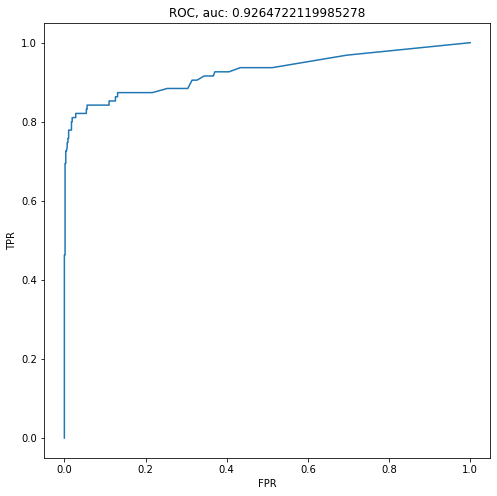

In [25]:
plt.rcParams['figure.figsize'] = 8,8
plt.plot(ftr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC, auc: " + str(auc))

Cross validate the model

## XGBoost cross validation parameters

- num_boost_round: denotes the number of trees you build (analogous to n_estimators)
- metrics: tells the evaluation metrics to be watched during CV
- as_pandas: to return the results in a pandas DataFrame.
- early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
- seed: for reproducibility of results.


In [26]:
params = {  'objective': "binary:logistic"
          , 'colsample_bytree': 0.9
          , 'learning_rate': 0.01
          , 'max_depth': 10
          , 'alpha': 0.5
          , 'min_child_weight': 1
          , 'subsample': 1
          , 'eval_metric': "auc"
          , 'n_estimators': 300
          , 'verbose': True
         }

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train) 

cv_results = xgb.cv(dtrain=data_dmatrix
                    , params=params
                    , nfold=5
                    , maximize = "auc"
                    , num_boost_round=100
                    , early_stopping_rounds=10
                    , metrics=["logloss", "error", "auc"]
                    , as_pandas=True
                    , seed=123
                    , verbose_eval=True
                   )

cv_results

[0]	train-auc:0.921533+0.00807297	train-error:0.0365722+0.00345008	train-logloss:0.684847+0.0001037	test-auc:0.899072+0.0266443	test-error:0.0615158+0.0153549	test-logloss:0.685205+0.000253096
[1]	train-auc:0.918103+0.00770359	train-error:0.035822+0.00343167	train-logloss:0.676853+0.00028859	test-auc:0.897627+0.0269152	test-error:0.0615166+0.0142642	test-logloss:0.677571+0.000453148
[2]	train-auc:0.923362+0.00558459	train-error:0.035634+0.00270392	train-logloss:0.669226+0.000352606	test-auc:0.896829+0.0280443	test-error:0.0637682+0.0175672	test-logloss:0.670414+0.000763792
[3]	train-auc:0.923363+0.00572027	train-error:0.034884+0.00273107	train-logloss:0.661607+0.000592359	test-auc:0.896745+0.0277124	test-error:0.0626424+0.0184112	test-logloss:0.663192+0.000821418
[4]	train-auc:0.923499+0.00549045	train-error:0.0349778+0.0026816	train-logloss:0.654104+0.000705886	test-auc:0.897508+0.0281374	test-error:0.0615174+0.0182119	test-logloss:0.656008+0.00103398
[5]	train-auc:0.923711+0.00533214

,train-auc-mean,train-auc-std,train-error-mean,train-error-std,train-logloss-mean,train-logloss-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std,test-logloss-mean,test-logloss-std
0,0.921533,0.008073,0.036572,0.00345,0.684847,0.000104,0.899072,0.026644,0.061516,0.015355,0.685205,0.000253


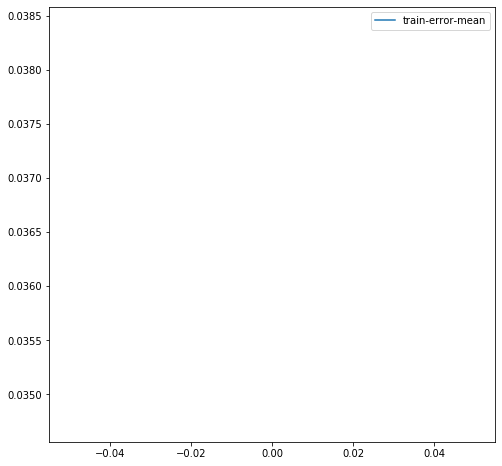

In [27]:
cv_results[["train-error-mean"]].plot()

Install graphviz to display the decision graph

```
$ conda install graphviz python-graphviz
```

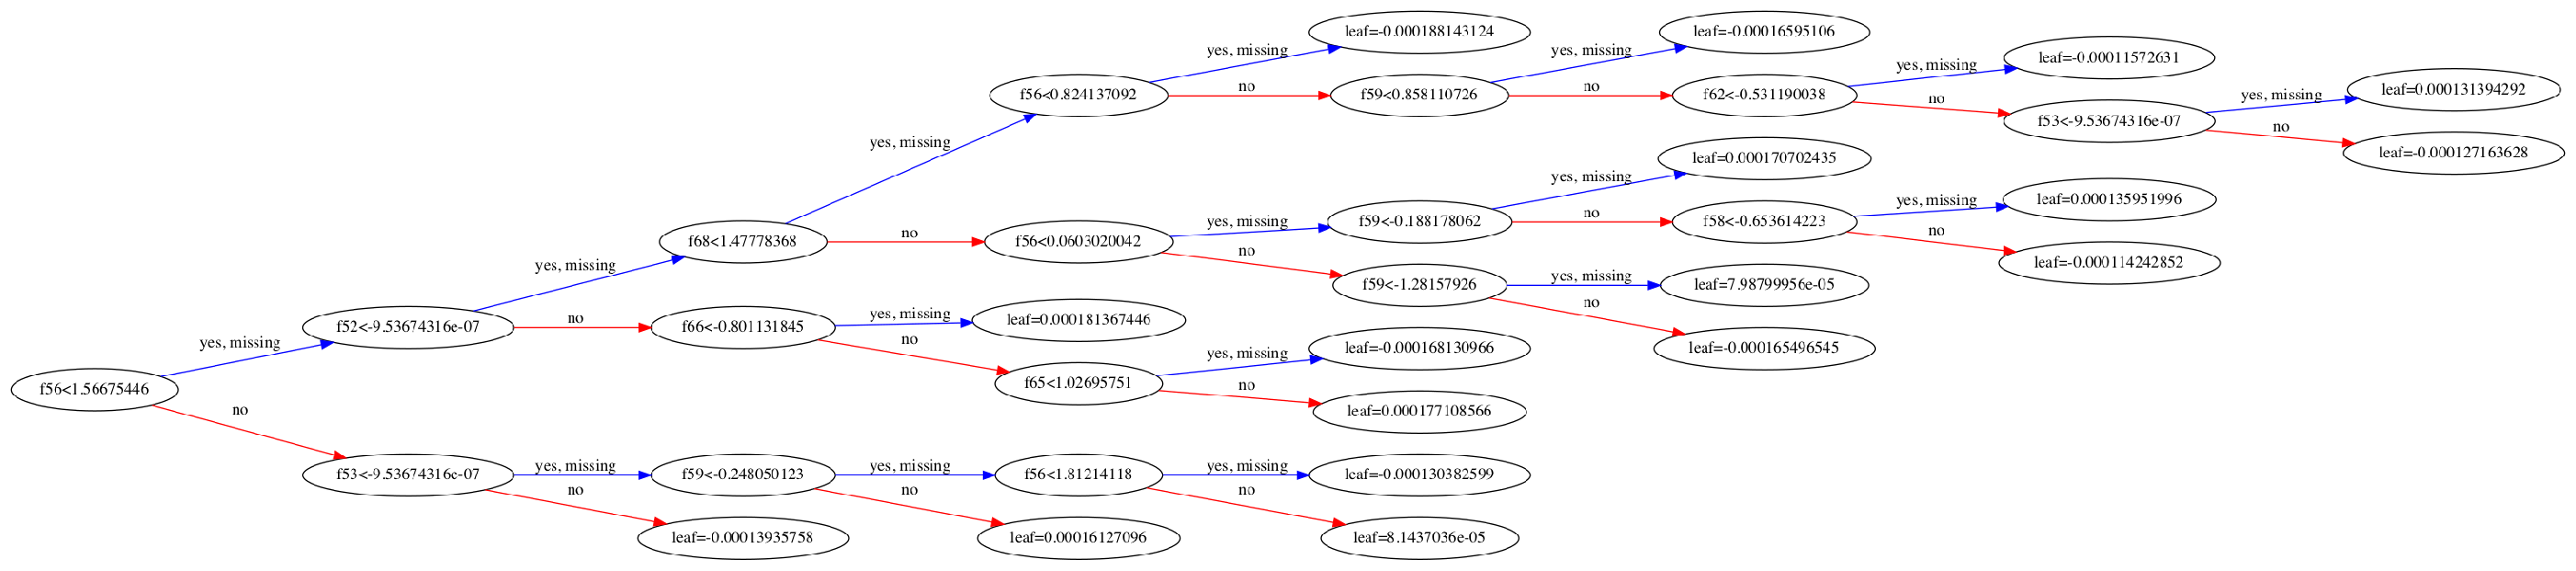

In [28]:
plt.rcParams['figure.figsize'] = 50,50

xgb.plot_tree(cls, num_trees=0, rankdir='LR')

These plots provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions.

Note that if the above plot throws the 'graphviz' error on your system, consider installing the graphviz package via pip install graphviz on cmd. You may also need to run sudo apt-get install graphviz on cmd.

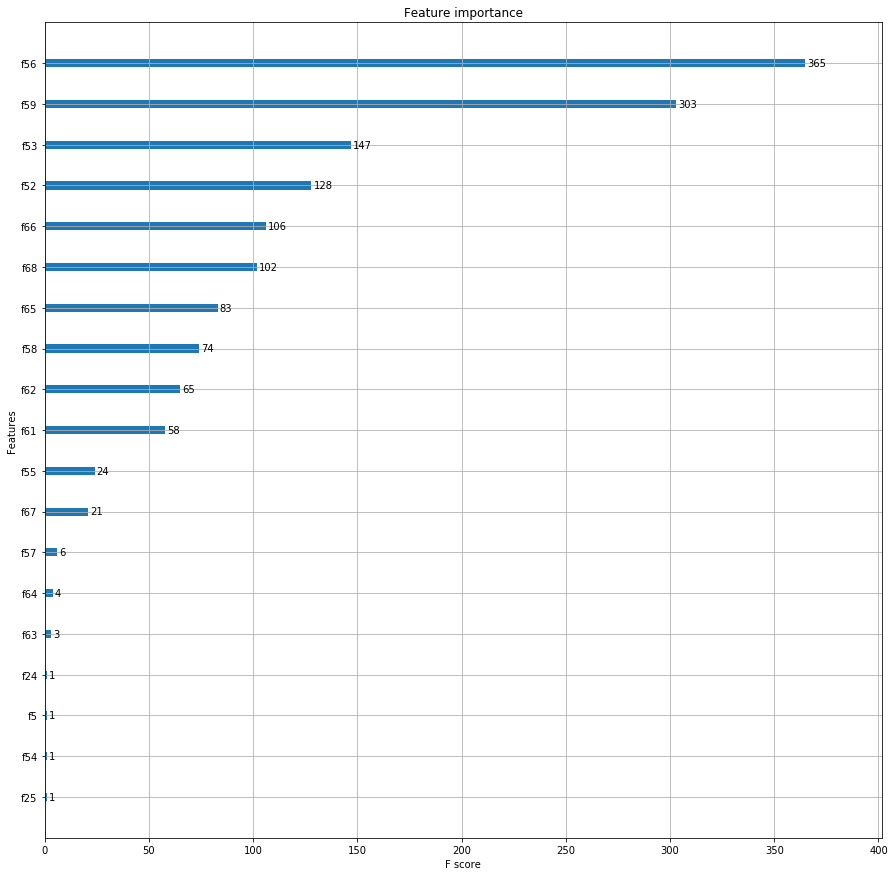

In [29]:
plt.rcParams['figure.figsize'] =15, 15
xgb.plot_importance(cls, )

In [30]:
cls.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01025054, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00170039,
       0.00204219, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10118318, 0.04199324, 0.00574934,
       0.03693115, 0.07571935, 0.00976875, 0.07445166, 0.03749925,
       0.        , 0.03856089, 0.02044625, 0.01984736, 0.02129499,
       0.10545638, 0.10491905, 0.10734642, 0.18483971], dtype=float32)

In [31]:
one_hot_encoder = preprocessing_pipe.transformers_[0][1].steps[1][1]
one_hot_encoder

OneHotEncoder(categories='auto', drop='first', dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [32]:
one_hot_encoder.get_feature_names()

array(['x0_AL', 'x0_AR', 'x0_AZ', 'x0_CA', 'x0_CO', 'x0_CT', 'x0_DC',
       'x0_DE', 'x0_FL', 'x0_GA', 'x0_HI', 'x0_IA', 'x0_ID', 'x0_IL',
       'x0_IN', 'x0_KS', 'x0_KY', 'x0_LA', 'x0_MA', 'x0_MD', 'x0_ME',
       'x0_MI', 'x0_MN', 'x0_MO', 'x0_MS', 'x0_MT', 'x0_NC', 'x0_ND',
       'x0_NE', 'x0_NH', 'x0_NJ', 'x0_NM', 'x0_NV', 'x0_NY', 'x0_OH',
       'x0_OK', 'x0_OR', 'x0_PA', 'x0_RI', 'x0_SC', 'x0_SD', 'x0_TN',
       'x0_TX', 'x0_UT', 'x0_VA', 'x0_VT', 'x0_WA', 'x0_WI', 'x0_WV',
       'x0_WY', 'x1_415', 'x1_510', 'x2_Yes', 'x3_Yes'], dtype=object)

In [33]:
preprocessing_pipe.transformers_[0][1]

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True,
                               fill_value='missing', missing_values=nan,
                               strategy='constant', verbose=0)),
                ('onehot',
                 OneHotEncoder(categories='auto', drop='first',
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='error', sparse=True))],
         verbose=False)

In [34]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}


cls = xgb.XGBRFClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.01,  
                          colsample_bytree = 0.99,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=100, 
                          reg_alpha = 0.003,
                          max_depth=10, 
                          gamma=10,
                          min_child_weight = 1
                         )

grid_search = model_selection.GridSearchCV(
    estimator=cls,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 12,
    cv = 10,
    verbose=True,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    9.3s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   26.9s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   50.4s
[Parallel(n_jobs=12)]: Done 960 out of 960 | elapsed:  1.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1,
                                       colsample_bynode=0.8,
                                       colsample_bytree=0.99, gamma=10,
                                       learning_rate=0.01, max_delta_step=0,
                                       max_depth=10, min_child_weight=1,
                                       missing=None, n_estimators=100, n_jobs=1,
                                       nthread=None,
                                       objective='binary:logistic',
                                       random_state=0, reg_alpha=0.003,
                                       reg_lambda=1, scale_pos_weight=1,
                                       seed=None, silent=False, subsample=0.8,
                                       verbosity=1),
             iid='deprecated', n_jobs=12,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                      

In [35]:
grid_search.best_estimator_

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.99, gamma=10, learning_rate=0.01,
                max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
                n_estimators=60, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0.003,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
                subsample=0.8, verbosity=1)

In [36]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 60}

In [37]:
grid_search.best_score_

0.9102904111517148

In [38]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.149544,0.008753,0.005663,0.001029,0.1,2,60,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.841768,0.869040,...,0.876419,0.878930,0.868219,0.870282,0.873559,0.875427,0.878467,0.866327,0.873710,0.004520
1,0.206796,0.004109,0.005612,0.000706,0.1,2,100,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.840643,0.869152,...,0.878967,0.880101,0.869855,0.870329,0.874219,0.873556,0.877827,0.863693,0.873758,0.004891
2,0.274844,0.005021,0.005403,0.000287,0.1,2,140,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.839238,0.870052,...,0.880513,0.880447,0.870322,0.872164,0.875337,0.873125,0.877370,0.869071,0.874927,0.003851
3,0.348550,0.004721,0.005465,0.000429,0.1,2,180,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.841206,0.869040,...,0.882023,0.883071,0.870990,0.870443,0.874660,0.872436,0.877211,0.868695,0.875305,0.004721
4,0.190961,0.005856,0.005865,0.001291,0.1,3,60,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.850990,0.902215,...,0.898055,0.898527,0.892299,0.889783,0.897592,0.894907,0.899457,0.886795,0.894677,0.004167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1.731979,0.043035,0.009813,0.002623,0.05,8,180,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.888270,0.941464,...,0.933009,0.934481,0.924315,0.920438,0.923470,0.922971,0.931564,0.918574,0.925977,0.005074
92,0.649170,0.017030,0.008285,0.002033,0.05,9,60,"{'learning_rate': 0.05, 'max_depth': 9, 'n_est...",0.889170,0.947650,...,0.928464,0.930433,0.920389,0.920887,0.921828,0.920205,0.929431,0.914081,0.923693,0.004857
93,1.041405,0.014829,0.008429,0.001413,0.05,9,100,"{'learning_rate': 0.05, 'max_depth': 9, 'n_est...",0.887314,0.943432,...,0.931600,0.933729,0.922440,0.920672,0.922962,0.922058,0.930330,0.917792,0.925106,0.004886
94,1.433208,0.040642,0.009050,0.001179,0.05,9,140,"{'learning_rate': 0.05, 'max_depth': 9, 'n_est...",0.886865,0.941970,...,0.933385,0.935089,0.924040,0.920403,0.923843,0.922945,0.931817,0.917976,0.925825,0.005390


In [39]:
folds = 5
param_comb = 5

cls = xgb.XGBRFClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.01,  
                          colsample_bytree = 0.99,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          n_estimators=100, 
                          reg_alpha = 0.003,
                          max_depth=10, 
                          gamma=10,
                          min_child_weight = 1
                         )

skf = model_selection.StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = model_selection.RandomizedSearchCV(cls, 
                                   param_distributions=parameters, 
                                   n_iter=param_comb, 
                                   scoring='accuracy', 
                                   n_jobs=12, 
                                   cv=skf.split(X_train,y_train), 
                                   verbose=3, 
                                   random_state=1001 )

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  11 out of  25 | elapsed:    1.4s remaining:    1.8s
[Parallel(n_jobs=12)]: Done  20 out of  25 | elapsed:    1.7s remaining:    0.4s
[Parallel(n_jobs=12)]: Done  25 out of  25 | elapsed:    1.8s finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x1a28595e50>,
                   error_score=nan,
                   estimator=XGBRFClassifier(base_score=0.5,
                                             colsample_bylevel=1,
                                             colsample_bynode=0.8,
                                             colsample_bytree=0.99, gamma=10,
                                             learning_rate=0.01,
                                             max_delta_step=0, max_depth=10,
                                             min_child_weight=1, missing=None,
                                             n_estimators=100, n_jobs=1,
                                             nthread=None,
                                             objective='binary:logistic',
                                             ran...eg_alpha=0.003,
                                             reg_lambda=1, scale_pos_weight=1,
                                            

In [40]:
random_search.best_score_, random_search.best_params_

(0.9373604289197603,
 {'n_estimators': 60, 'max_depth': 7, 'learning_rate': 0.1})

In [41]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.409287,0.043595,0.013272,0.001676,180,8,0.01,"{'n_estimators': 180, 'max_depth': 8, 'learnin...",0.928839,0.930582,0.953096,0.938086,0.934334,0.936987,0.008662,2
1,0.398917,0.004048,0.009777,0.000498,180,2,0.1,"{'n_estimators': 180, 'max_depth': 2, 'learnin...",0.850187,0.893058,0.893058,0.874296,0.857411,0.873602,0.017709,5
2,0.969388,0.009220,0.013126,0.000999,180,5,0.1,"{'n_estimators': 180, 'max_depth': 5, 'learnin...",0.925094,0.926829,0.953096,0.938086,0.934334,0.935488,0.010011,3
3,0.571424,0.021647,0.008289,0.001412,140,4,0.05,"{'n_estimators': 140, 'max_depth': 4, 'learnin...",0.900749,0.926829,0.917448,0.938086,0.923077,0.921238,0.012269,4
4,0.355145,0.048288,0.005679,0.001454,60,7,0.1,"{'n_estimators': 60, 'max_depth': 7, 'learning...",0.934457,0.930582,0.947467,0.936210,0.938086,0.937360,0.005628,1
